In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
import tensorflow_probability as tfp

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata

In [4]:
from zoobot.active_learning.metrics import IterationState
import pickle

In [5]:
os.chdir('/home/walml/repos/zoobot')

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [7]:

state_loc = 'results/4q/latest_dirichlet_unfiltered_active_m3_warm/iteration_0/state.pickle'
label_cols = label_metadata.gz2_partial_label_cols
questions = label_metadata.gz2_partial_questions


# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'gz2'
schema = losses.Schema(label_cols, questions, version=version)

batch_size = 8
initial_size = 300
# initial_size = 128
crop_size = int(initial_size * 0.75)
# crop_size = 128
final_size = 224
channels = 3

n_samples = 10


{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after smooth-or-featured_featured-or-disk, index 1: (2, 3), bar, indices 4 to 5, asked after smooth-or-featured_featured-or-disk, index 1: (4, 5), bulge-size, indices 6 to 9, asked after smooth-or-featured_featured-or-disk, index 1: (6, 9)}


In [8]:

with open(state_loc, 'rb') as f:
    state = pickle.load(f)

In [9]:

samples_list = state.samples
n_models = len(state.samples)
state.samples[0].shape, state.acquisitions.shape, len(state.id_strs)


((40960, 10, 5), (40960,), 40960)

In [10]:
state.id_strs[7654]

'dr7objid_587734623247794243'

In [11]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [12]:
n_samples = samples_list[0].shape[2]

In [13]:
from zoobot.estimators import losses


In [14]:
data = []
for n in range(len(state.id_strs)):
    data.append({'n': n, 'id_str': state.id_strs[n], 'samples': np.array([state.samples[m][n] for m in range(n_models)])}) 
galaxy_df = pd.DataFrame(data=data)
before_match = len(galaxy_df)
galaxy_df = pd.merge(galaxy_df, catalog, on='id_str', how='inner')
assert len(galaxy_df) == before_match


In [15]:
answer_cols = [a.text for a in schema.answers]
labels = galaxy_df[answer_cols].values
predictions = galaxy_df['samples'].values
predictions_model_0 = np.array([p[0] for p in predictions])

predictions_model_0.shape, labels.shape

((40960, 10, 5), (40960, 10))

In [16]:
len(predictions)

40960

In [17]:
predictions[0].shape

(2, 10, 5)

In [18]:
predictions_stacked = np.stack(predictions)
predictions_stacked.shape

(40960, 2, 10, 5)

In [19]:
predictions_by_model = [predictions_stacked[:, n] for n in range(n_models)]
predictions_by_model[0].shape

(40960, 10, 5)

In [20]:
predictions_model_all = np.concatenate(predictions_by_model, axis=2)

predictions_model_all.shape, labels.shape

((40960, 10, 10), (40960, 10))

In [21]:
from zoobot.active_learning import acquisition_utils
from zoobot.estimators import dirichlet_stats

In [28]:
def dropout_loss_multiq(labels, predictions, question_index_groups):  # pasted
    q_losses = []
    for q_n in range(len(question_index_groups)):
        q_indices = question_index_groups[q_n]
        q_start = q_indices[0]
        q_end = q_indices[1]
        q_loss = dropout_loss(labels[:, q_start:q_end+1], predictions[:, q_start:q_end+1])
        q_losses.append(q_loss)
    
    total_loss = tf.stack(q_losses, axis=1)
    return total_loss  # leave the reduce_sum to the estimator

def dropout_loss(labels_q, predictions_q):
    n_samples = predictions_q.shape[-1]
    total_votes = labels_q.sum(axis=1).squeeze()
    log_probs = []
#     print(predictions_q.shape,total_votes.shape, n_samples)
    for n, galaxy in enumerate(predictions_q):
        predictions_g = np.expand_dims(galaxy, axis=0)
        mixture = dirichlet_stats.DirichletMultinomialEqualMixture(total_votes[n], predictions_g)
        log_probs.append(mixture.log_prob(labels_q[n]))
    return -np.squeeze(np.array(log_probs))  # negative log prob

In [29]:
predictions_model_all.shape

(40960, 10, 10)

In [30]:

loss_0 = losses.multiquestion_loss(tf.constant(labels, dtype=tf.float32), tf.constant(predictions_model_0[:, :, 0], dtype=tf.float32), schema.question_index_groups)
loss_0.shape

TensorShape([40960, 4])

In [31]:
loss_0.numpy().mean()

1.9717615

In [32]:
loss_all = dropout_loss_multiq(labels.astype(np.float32), predictions_model_all[:50], schema.question_index_groups)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Sample last-dimension must sum to `1`.'
b'x and y not equal to tolerance rtol = tf.Tensor(1.1920929e-06, shape=(), dtype=float32), atol = tf.Tensor(1.1920929e-06, shape=(), dtype=float32)'
b'x (shape=() dtype=float32) = '
1.0
b'y (shape=() dtype=float32) = '
46.0

In [ ]:
loss_all = loss_all.numpy().squeeze()

In [ ]:
loss_all.mean()

In [27]:
plt.hist(loss_all[:, 0], bins=30)

NameError: name 'loss_all' is not defined

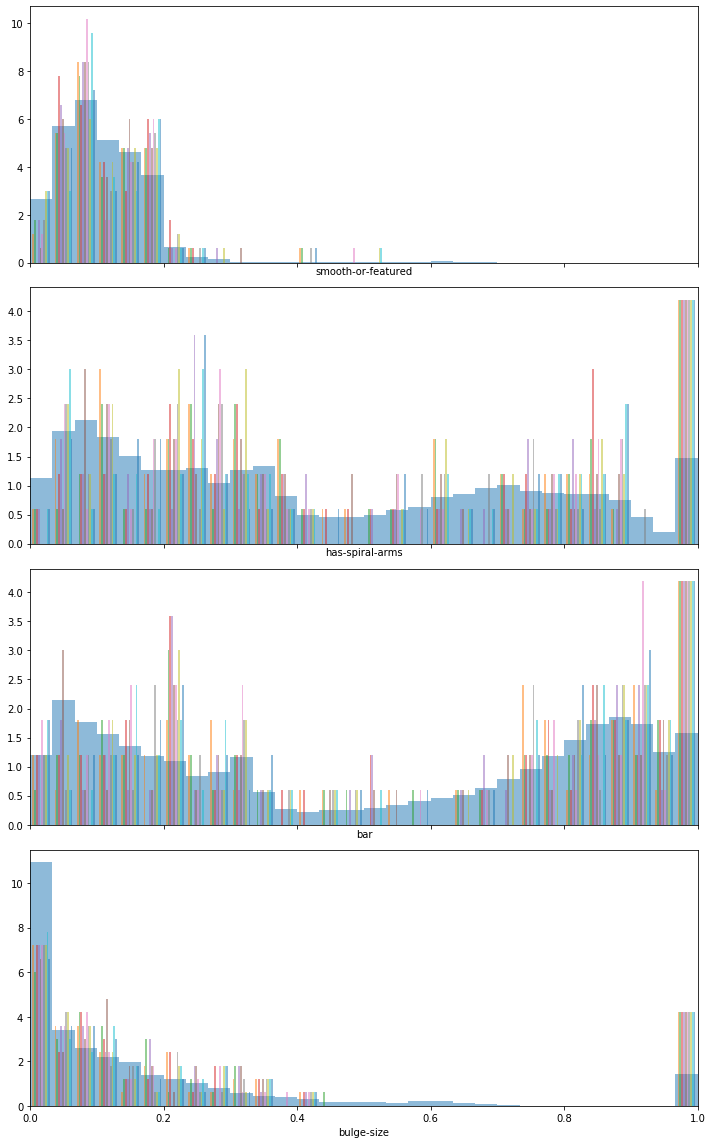

In [72]:
fig, axes = plt.subplots(nrows=len(schema.questions), figsize=(10, 16), sharex=True)
_, bins = np.histogram(np.linspace(0, 1.), bins=30)

for q_n, question in enumerate(schema.questions):
    ax = axes[q_n]
    q_loss_0 = np.e ** -loss_0[:, q_n]
    q_loss_all = np.e ** -loss_all[:, q_n]
    ax.hist(q_loss_0, bins=bins, alpha=.5, density=True)
    ax.hist(q_loss_all, bins=bins, alpha=.5, density=True)
    ax.set_xlabel(question.text)
    ax.set_xlim([0, 1])
fig.tight_layout()

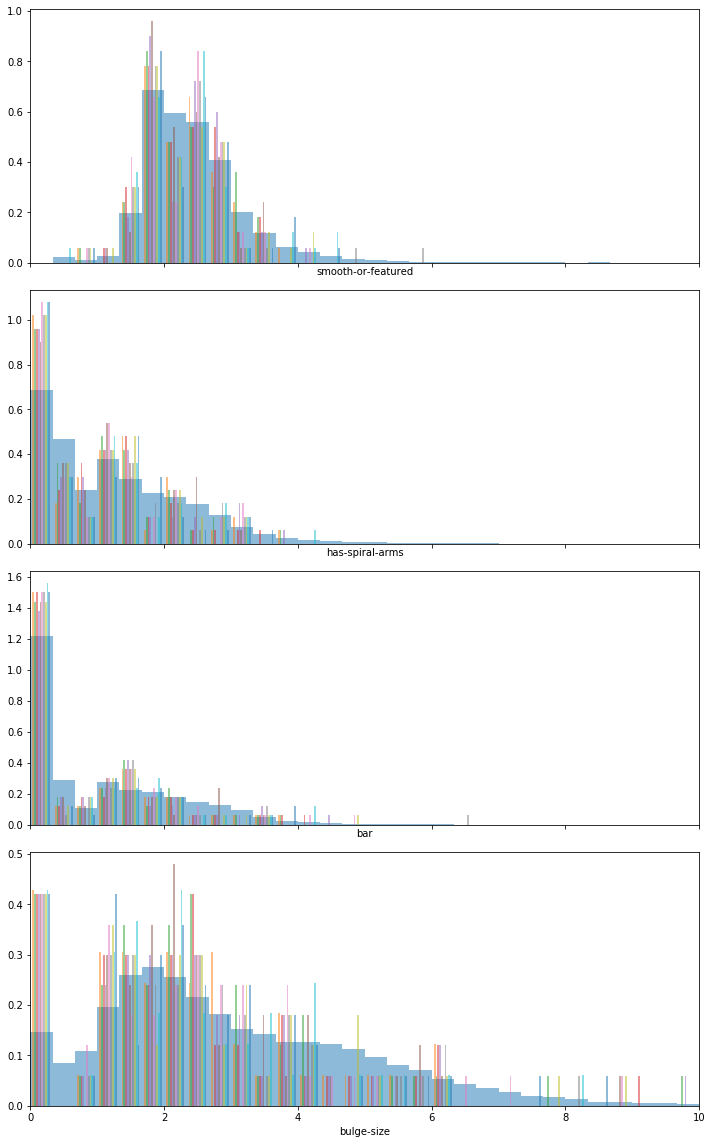

In [73]:
fig, axes = plt.subplots(nrows=len(schema.questions), figsize=(10, 16), sharex=True)
_, bins = np.histogram(np.linspace(0, 10), bins=30)
for q_n, question in enumerate(schema.questions):
    ax = axes[q_n]
    q_loss_0 = loss_0[:, q_n]
    q_loss_all = loss_all[:, q_n]
    ax.hist(q_loss_0, bins=bins, alpha=.5, density=True)
    ax.hist(q_loss_all, bins=bins, alpha=.5, density=True)
    ax.set_xlabel(question.text)
    ax.set_xlim([0, 10])
fig.tight_layout()

In [74]:
# loss_all_q_0 = loss_0
# loss_all_q_all = loss_all

# loss_four_q_0 = loss_0
# loss_four_q_all = loss_all

In [75]:
# plt.hist(loss_all_q_0[:, 3], alpha=.5, bins=30)
# plt.hist(loss_four_q_0[:, 2], alpha=.5, bins=30)


In [76]:
# _, bins = np.histogram(np.linspace(0., 8.), bins=30)
# plt.hist(loss_all_q_0[:, 0], alpha=.5, bins=bins)
# plt.hist(loss_four_q_0[:, 0], alpha=.5, bins=bins)


In [77]:
# _, bins = np.histogram(np.linspace(0., 8.), bins=30)
# plt.hist(loss_all_q_0[:, 2], alpha=.5, bins=bins)
# plt.hist(loss_four_q_0[:, 1], alpha=.5, bins=bins)


In [78]:
# _, bins = np.histogram(np.linspace(0., 8.), bins=30)
# plt.hist(loss_all_q_0[:, 4], alpha=.5, bins=bins)
# plt.hist(loss_four_q_0[:, 3], alpha=.5, bins=bins)


In [79]:
# loss_all_q_0.shape, loss_four_q_0.shape

In [80]:
# loss_0[4]

In [81]:
# loss_all[4]

In [82]:
import matplotlib as mpl
cycler = mpl.rcParams['axes.prop_cycle']
# https://matplotlib.org/cycler/
colors = [c['color'] for c in cycler]

In [83]:
question._asked_after.text

'smooth-or-featured_featured-or-disk'

In [84]:
catalog.columns.values

array(['index', 'dr7objid', 'ra', 'dec', 'sample',
       'smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk',
       'smooth-or-featured_artifact', 'disk-edge-on_yes',
       'disk-edge-on_no', 'bar_yes', 'bar_no', 'has-spiral-arms_yes',
       'has-spiral-arms_no', 'bulge-size_no',
       'bulge-size_just-noticeable', 'bulge-size_obvious',
       'bulge-size_dominant', 'something-odd_yes', 'something-odd_no',
       'how-rounded_round', 'how-rounded_in-between', 'how-rounded_cigar',
       'bulge-shape_round', 'bulge-shape_boxy', 'bulge-shape_no-bulge',
       'spiral-winding_tight', 'spiral-winding_medium',
       'spiral-winding_loose', 'spiral-count_1', 'spiral-count_2',
       'spiral-count_3', 'spiral-count_4', 'spiral-count_more-than-4',
       'spiral-count_cant-tell', 'local_png_loc', 'png_ready',
       'smooth-or-featured_total-votes', 'disk-edge-on_total-votes',
       'bar_total-votes', 'has-spiral-arms_total-votes',
       'bulge-size_total-votes', 'someth

In [121]:
def show_predictions(samples_list, catalog, id_strs, question, answer, sort_order=None, n_examples=5):  
    
    if sort_order is None:
        id_str_sorted = id_strs
#         catalog_sorted = catalog
    else:
#         catalog_sorted = catalog[sort_order]
        id_str_sorted = [id_strs[n] for n in sort_order]

    fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(7, 2.5 * n_examples))
    for n in range(n_examples):
        
        galaxy = catalog[catalog['id_str'] == id_str_sorted[n]].squeeze()

        row = axes[n]
        total_votes = galaxy[question.text + '_total-votes'].astype(np.float32)
        votes = np.linspace(0., total_votes)
        x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
        votes_this_answer = x[:, answer.index - question.start_index]

#         losses = []
        for model_n, samples in enumerate(samples_list):

            if sort_order is None:
                samples_sorted = samples
            else:
                samples_sorted = samples[sort_order]

            ax = row[0]
            ax.set_ylabel(r'$p$(Votes)')

            all_probs = []
            color = colors[model_n]
            n_samples = samples.shape[2]
            for d in range(n_samples):
                concentrations = tf.constant(samples_sorted[n, question.start_index:question.end_index+1, d].astype(np.float32))
                probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
                all_probs.append(probs)
                ax.plot(votes_this_answer, probs, alpha=.15, color=color)
            mean_probs = np.array(all_probs).mean(axis=0)
            ax.plot(votes_this_answer, mean_probs, linewidth=2., color=color)
            ax.axvline(galaxy[answer.text], color='k', linestyle='--')
            
            answer_index = np.argmin(np.abs(galaxy[answer.text] - votes_this_answer))
            prob_of_answer = mean_probs[answer_index]
#             ax.set_title('{:.4f}, {:2.2f}'.format(prob_of_answer, -np.log(prob_of_answer)))
            ax = row[1]
            ax.imshow(np.array(Image.open(galaxy['file_loc'])))
            ax.axis('off')
        row[0]
            
        axes[-1][0].set_xlabel(answer.text + ' Votes')
        
fig.tight_layout()

In [126]:
# question = schema.get_question('smooth-or-featured')
question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
answer = question.answers[1]
answer.text

'has-spiral-arms_no'

In [127]:
for n in range(10):
    print(loss_0[n].numpy()[0], loss_all[n][0])

1.7961655 [1.7961655 1.770256  1.7704391 1.7674179 1.7738266 1.7697067 1.7725143
 1.7755356 1.7674179 1.7791672]
2.5869064 [2.5869064 2.7760544 2.425743  2.6070023 2.369667  2.4127731 2.4460526
 2.73629   2.4277954 2.6144562]
1.6578064 [1.6578064 1.5435181 1.5559082 1.5950623 1.637207  1.6269226 1.6036682
 1.6017456 1.6359863 1.6773376]
1.9000854 [1.9000854 1.8981628 1.9840088 1.9273376 1.8613281 1.9231262 1.8634949
 1.8703613 1.9198608 1.888031 ]
3.481247 [3.481247  3.2693176 3.3406448 3.5570755 3.351242  3.5698013 3.5455093
 4.0942993 4.1127014 3.7323074]
2.6591415 [2.6591415 2.5659714 2.5085678 2.8472214 2.5403976 2.515709  2.6107712
 2.4013596 2.7333908 2.5561142]
1.3581924 [1.3581924 1.3760147 1.3233185 2.2222672 1.8680191 1.6114731 1.4542542
 1.5840454 1.3995819 1.3916473]
3.182022 [3.182022  3.0407867 2.6668472 3.1782684 3.0772018 2.6350784 2.836792
 2.9681015 2.5492477 2.9520035]
2.481285 [2.481285  2.340622  2.3818283 2.3740768 2.3113785 2.3399658 2.3543015
 2.3984985 2.387626

In [128]:
import random

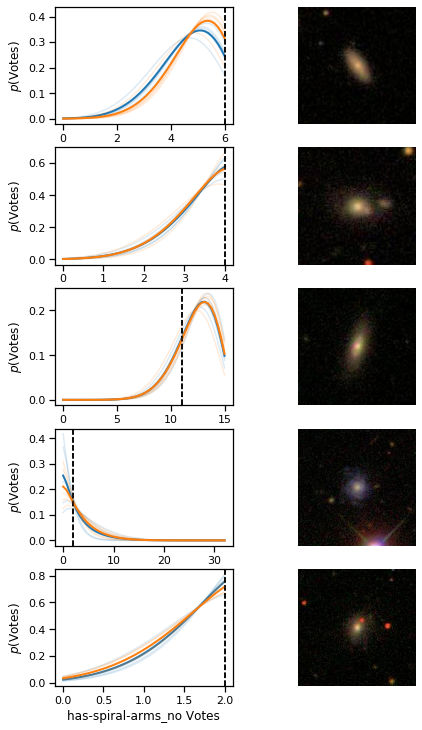

In [129]:
sns.set_context('notebook')
random_order = np.arange(len(samples_list[0]))
random.shuffle(random_order)
show_predictions(samples_list, catalog, state.id_strs, question, answer, sort_order=random_order, n_examples=5)
# for n in range(10):
#     print(loss_all[n][0])

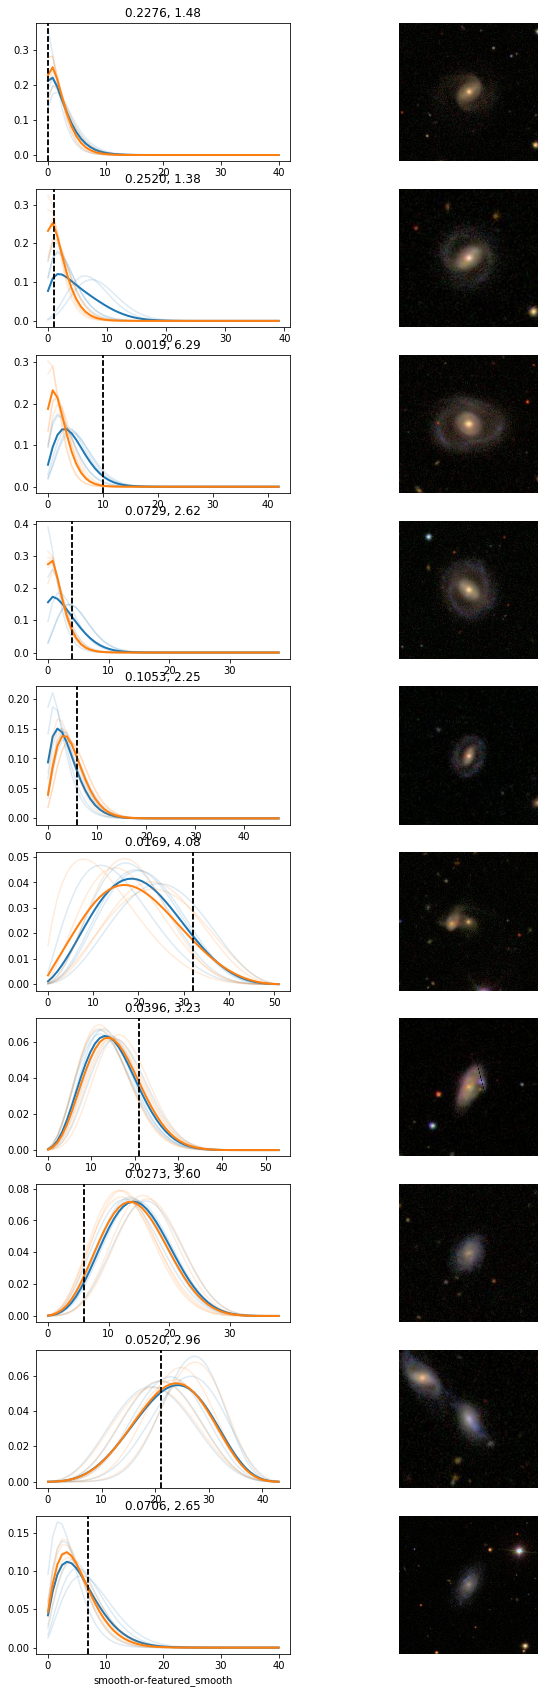

In [92]:
show_predictions(samples_list, catalog, state.id_strs, question, answer, sort_order=np.argsort(state.acquisitions), n_examples=10)

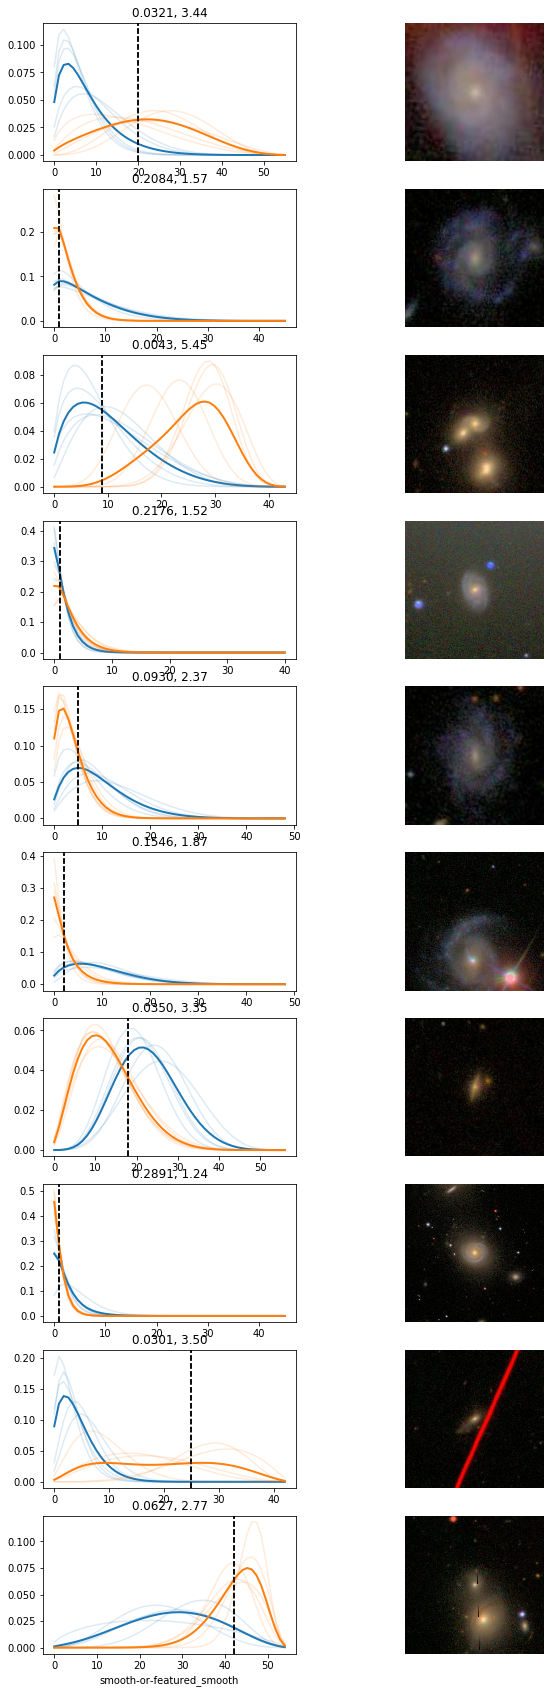

In [93]:
show_predictions(samples_list, catalog, state.id_strs, question, answer, sort_order=np.argsort(state.acquisitions)[::-1], n_examples=10)  # for allq, red line on galaxy 4

In [ ]:
(state.acquisitions < -98.).sum()

In [ ]:
state.acquisitions[state.acquisitions < -98] = 0  # for now

In [ ]:
plt.hist(state.acquisitions, bins=30)

In [ ]:
plt.hist(np.log10(state.acquisitions + 1e-8), bins=30)

In [ ]:
state.acquisitions

In [ ]:
acq_df = pd.DataFrame(data={'id_str': state.id_strs, 'acquisition': state.acquisitions})
df = pd.merge(acq_df, catalog, on='id_str', how='left')

In [ ]:
df['has-spiral-arms_fraction'] = df['has-spiral-arms_yes'] / df['has-spiral-arms_total-votes']
df['smooth-or-featured_fraction'] = df['smooth-or-featured_smooth'] / df['smooth-or-featured_total-votes']
df['log_acquisition'] = np.log10(df['acquisition']+1e-5)

In [ ]:
# copied from touch table
def quality_check(df, n_bins=10, n_galaxies_per_bin=10):

#     df['binned_acq'], bins = pd.cut(df['acquisition'], n_bins, labels=False, retbins=True)
    df['binned_acq'], bins = pd.cut(df['log_acquisition'], n_bins, labels=False, retbins=True)
    print(bins)
    print(df['binned_acq'].value_counts())
    
    scale = 3
    plt.figure(figsize=(scale * n_galaxies_per_bin, scale * n_bins))
    gs1 = gridspec.GridSpec(n_galaxies_per_bin, n_bins)
    gs1.update(wspace=0.0, hspace=0.0)
    for bin_n in range(n_bins):
        selected_df = df.query('binned_acq == {}'.format(bin_n))
        selected_df = selected_df.sample(len(selected_df))  # shuffle
        for galaxy_n in range(n_galaxies_per_bin):
            if galaxy_n < len(selected_df):
                galaxy = selected_df.iloc[galaxy_n]
                image = Image.open(galaxy['file_loc'])
                ax = plt.subplot(gs1[galaxy_n, bin_n])
                ax.imshow(image)
#                 ax.text(50, 50, 'Spiral = {:.2f}'.format(galaxy['has-spiral-arms_fraction']), fontsize=16, color='r')
#                 ax.text(50, 120, 'N = {}'.format(galaxy['total']), fontsize=16, color='r')
                if galaxy_n == 0:
                    ax.text(80, -50, 'Feat: {:.2f} to {:.2f}'.format(bins[bin_n], bins[bin_n + 1]), fontsize=16, color='black')
                ax.axis('off')
#     plt.savefig('touch_table_retirement_{}.pdf'.format(retirement_limit))
    return df

In [ ]:
catalog.columns.values

In [ ]:
sns.jointplot(df['log_acquisition'], df['smooth-or-featured_fraction'], kind='hex')

In [ ]:
df.sort_values('log_acquisition', ascending=False).iloc[1024]['log_acquisition']

In [ ]:
df.sort_values('log_acquisition', ascending=False).iloc[int(len(df)/3)]['log_acquisition']

In [ ]:
_ = quality_check(df, n_bins=10)

In [ ]:
_ = quality_check(df.query('log_acquisition > -3.5'), n_bins=10)

In [ ]:
assert False

In [ ]:
# high acquisition
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(20, 6))
all_axes = [ax for row in axes for ax in row]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[np.argsort(state.acquisitions)[::-1][subject_n]]
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')
fig.tight_layout()

In [ ]:
# random
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(20, 6))
all_axes = [ax for row in axes for ax in row]
for subject_n in range(24):
    ax = all_axes[subject_n]
    loc = catalog.sample().squeeze()['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')
fig.tight_layout()

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+50]]  # 50th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+500]]  # 500th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    if os.path.isfile(loc):
        ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+1000]]  # 1000th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    if os.path.isfile(loc):
        ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[np.argsort(state.acquisitions)[subject_n]]
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
# just generally low acquisition, but not the lowest
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[np.argsort(state.acquisitions)[500:][subject_n]]
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
from zoobot.active_learning import iterations

In [ ]:
subjects = [{'id_str': x} for x in state.id_strs]
top_subjects, top_ids = iterations.pick_top_subjects(subjects, state.acquisitions, n_subjects_to_acquire=10)

In [ ]:
state.id_strs[np.argsort(state.acquisitions)[::-1][0]]

In [ ]:
top_ids

In [ ]:
import json

In [ ]:
subjects = [{'id_str': x} for x in state.id_strs]
top_subjects, top_ids = iterations.pick_top_subjects(subjects, state.acquisitions, n_subjects_to_acquire=1024)
with open('results/temp/temp_ids.json', 'w') as f:
    json.dump(top_ids, f)
f.close()

In [ ]:
worst_id = state.id_strs[np.argsort(state.acquisitions)[::-1][7341]]
worst_id

In [ ]:
state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_3/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)

In [ ]:
# high acquisition
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(20, 6))
all_axes = [ax for row in axes for ax in row]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[np.argsort(state.acquisitions)[::-1][subject_n]]
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    if os.path.isfile(loc):
        ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')
fig.tight_layout()

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+50]]  # 50th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    if os.path.isfile(loc):
        ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
# low acquisition, often low confidence as uncertain
fig, axes = plt.subplots(nrows=3, ncols=8, sharex=True, figsize=(24, 8))
all_axes = [ax for row in axes for ax in row]
sort = np.argsort(state.acquisitions)[::-1]
for subject_n in range(24):
    ax = all_axes[subject_n]
    id_str = state.id_strs[sort[subject_n+500]]  # 500th to be acquired, but still acquired
    matched_row = catalog[catalog['id_str'] == id_str].squeeze()
    loc = matched_row['file_loc']
    if os.path.isfile(loc):
        ax.imshow(np.array(Image.open(loc)))
    ax.axis('off')

In [ ]:
state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_0/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)
acq_0_ids = set(state.id_strs)

print(len(acq_0_ids))

state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_1/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)
acq_1_ids = set(state.id_strs)

print(len(acq_1_ids))

state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_2/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)
acq_2_ids = set(state.id_strs)

print(len(acq_2_ids))

state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_3/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)
acq_3_ids = set(state.id_strs)

print(len(acq_3_ids))


state_loc = 'results/temp/latest_dirichlet_active_n5/iteration_4/state.pickle'
with open(state_loc, 'rb') as f:
    state = pickle.load(f)
acq_4_ids = set(state.id_strs)

print(len(acq_4_ids))

In [ ]:
safe_catalog = pd.read_csv('results/temp/safe_catalog.csv')

In [ ]:
id_str_df = pd.DataFrame(data=[{'id_str': x} for x in id_strs])[:100]  # NEW only first 100 of 1000, the weird ones
len(id_str_df)

In [ ]:
acquired_df = pd.merge(safe_catalog, df_a, on='dr7objid', how='inner', suffixes=('_catalog', ''))
len(acquired_df)

In [ ]:

relevant_physical_cols = ['mag', 'sersic_absmag_r', 'z', 'log_sersic_mass', 'petro_ba50', 'petro_ba90', 'petro_theta', 'asymmetry_r', 'clumpy_r', 'ra', 'dec']

fig, axes = plt.subplots(figsize=(8, 18), nrows=len(relevant_physical_cols))
alpha = .5

# _, bins = np.histogram(np.linspace(0., 1.), bins=30)
bins=30


for (n, col) in enumerate(relevant_physical_cols):
    col = col.lower()
    ax = axes[n]
    ax.hist(safe_catalog[col], alpha=alpha, label='Catalog', density=True, bins=bins)
    ax.hist(acquired_df.sort_values('acquisition_mean')[col], alpha=alpha, label='Acquired', density=True, bins=bins)
    ax.set_xlabel(col)
    ax.legend()
    fig.tight_layout()

In [ ]:
galaxy = galaxy_df.iloc[4]
model_0_d0 = predictions[4][0, :2, 0]  # galaxy 4 model 0 first 2 answers, 0th dropout
print(model_0_example_preds)
print(model_0_example_preds.shape)


total_votes = np.array(galaxy['smooth-or-featured_smooth'] + galaxy['smooth-or-featured_featured-or-disk']).astype(np.float32)  # total votes is not correct here as I forgot artifact
outcome = (galaxy['smooth-or-featured_smooth'], galaxy['smooth-or-featured_featured-or-disk'])
print(outcome)

# print(tfp.distributions.DirichletMultinomial(total_votes, model_0_example_preds))
print(tfp.distributions.DirichletMultinomial(total_votes, model_0_d0).log_prob(outcome))

In [ ]:
model_0_d0.shape

In [ ]:
model_0_dall = predictions[4][0, :2, :]  # galaxy 4 model 0 first 2 answers, all dropout
model_0_dall.shape

In [ ]:
all_outcomes = np.array([np.arange(0, total_votes+1), np.arange(0, total_votes+1)[::-1]])
all_outcomes

In [ ]:
acquisition_utils.dirichlet_mixture(np.expand_dims(model_0_dall, axis=0), total_votes, n_samples).log_prob(outcome)

In [ ]:
model_all_dall = np.concatenate([predictions[4][m, :2, :] for m in range(n_models)], axis=1)  # galaxy 4 model m first 2 answers, all dropout
model_all_dall.shape

In [ ]:
np.log(acquisition_utils.dirichlet_mixture(np.expand_dims(model_all_dall, axis=0), total_votes, n_samples * n_models).prob(outcome))

In [ ]:
print(np.log(tfp.distributions.DirichletMultinomial(total_votes, model_all_dall.transpose()).prob(outcome)))

In [ ]:
print(np.log(np.mean(tfp.distributions.DirichletMultinomial(total_votes, model_all_dall.transpose()).prob(outcome))))

In [ ]:
# print(np.log(tfp.distributions.DirichletMultinomial([total_votes for n in range(10)], model_all_dall.transpose()).prob(outcome)))

In [ ]:
all_outcomes.shape

In [ ]:
plt.plot(all_outcomes[0, :], tfp.distributions.DirichletMultinomial(total_votes, model_0_d0).log_prob(all_outcomes.transpose()))

In [ ]:
model_all_dall.shape

In [ ]:
acquisition_utils.dirichlet_mixture(np.expand_dims(model_all_dall, axis=0), total_votes, n_samples * n_models)

In [ ]:
total_votes

In [ ]:
all_outcomes

In [ ]:
plt.plot(all_outcomes[0, :], tfp.distributions.DirichletMultinomial(total_votes, model_0_d0).log_prob(all_outcomes.transpose()))

plt.plot(
    all_outcomes[0, :],
    np.log(acquisition_utils.dirichlet_mixture(np.expand_dims(model_all_dall, axis=0), total_votes, n_samples * n_models).prob(all_outcomes.transpose()))
)

plt.ylim([-5, None])

In [ ]:
model_all_dall.shape

In [ ]:
# plt.plot(all_outcomes[0, :], tfp.distributions.DirichletMultinomial(total_votes, model_0_d0).prob(all_outcomes.transpose()), label='m0d0')

# plt.plot(
#     all_outcomes[0, :],
#     acquisition_utils.dirichlet_mixture(np.expand_dims(model_all_dall[:, -2:], axis=0), total_votes, 2).prob(all_outcomes.transpose()),
#     label='m1d-2'
# )
plt.plot(
    all_outcomes[0, :],
    acquisition_utils.dirichlet_mixture(np.expand_dims(model_all_dall, axis=0), total_votes, n_samples * n_models).prob(all_outcomes.transpose()),
    label='m_all_d_all',
    linewidth=3.
)
plt.legend()
# plt.ylim([-5, None])

for d in range(10):
    
    plt.plot(all_outcomes[0, :], tfp.distributions.DirichletMultinomial(total_votes, model_all_dall[:, d]).prob(all_outcomes.transpose()), color='k', alpha=.2)


plt.axvline(galaxy['smooth-or-featured_smooth'], color='r')

7168 / 2 = 3584?